In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import numpy.linalg as la
from scipy import linalg

In [2]:
class Functions:
    def __init__(self):
        """
        entries of the form:
        [
        x0 = x,
        f(x) = f,
        f'(x) = g,
        f''(x) = h
        ]
        """
        self.function_list = [
            [
            # f1:
            # extrema: 7, 3, 1
            np.array([2], dtype=np.longdouble),
            lambda x: np.array(0.25*x**4 - (11/3)*x**3 + (31/2)*x**2 - 21*x),
            lambda x: np.array((x-7)*(x-3)*(x-1)),
            lambda x: np.array([3*x**2 - 22*x + 31]),
            ], [
            # f2:
            # extrema: -5, 4, -3, 2
            np.array([2.1], dtype=np.longdouble),
            lambda x: np.array(0.2*x**5 + 0.5*x**4 - (25/3)*x**3 - 13*x**2 + 120*x),
            lambda x: np.array((x+5)*(x-4)*(x+3)*(x-2)),
            lambda x: np.array([4*x**3 + 6*x**2 - 50*x - 26]),
            ], [
            # f3:
            # extrema: 1, 3, 2
            np.array([1.5], dtype=np.longdouble),
            lambda x: np.array(0.25*x**4 - 2*x**3 + (11/2)*x**2 - 6*x),
            lambda x: np.array((x-1)*(x-3)*(x-2)),
            lambda x: np.array([3*x**2 - 12*x + 11]),
            ], [
            # f4:
            # extrema: -3, 0, 3, 5
            np.array([4], dtype=np.longdouble),
            lambda x: np.array(0.2*x**5 - (5/4)*x**4-3*x**3 + (45/2)*x**2),
            lambda x: np.array((x+3)*x*(x-3)*(x-5)),
            lambda x: np.array([4*x**3 - 15*x**2 - 18*x + 45]),
            ], [
            # f5:
            # stationary: 0
            np.array([0.5], dtype=np.longdouble),
            lambda x: np.array(-np.cos(3*x)+(3/4)*x**4),
            lambda x: np.array(3*np.sin(3*x)+3*x**3),
            lambda x: np.array([9*(np.cos(3*x) + x**2)]),
            ], [
            # special function (1) - Rosenbrock function
            # stationary point: (1,1)
            np.array([-1.2, 1], dtype=np.longdouble),
            lambda x: np.array(100*(x[1]-x[0]**2)**2 + (1-x[0])**2),
            lambda x: np.array([400*x[0]**3-2*x[0]*(200*x[1]-1)-2, 200*x[1]-200*x[0]**2]),
            lambda x: np.array([[1200*x[0]**2-2*(200*x[1]-1), -400*x[0]], [-400*x[0], 200]])
            ], [
            # special function (2) - nameless
            np.array([-1, 0], dtype=np.longdouble),
            lambda x: np.array([150*(x[0]*x[1])**2 + (0.5*x[0]+2*x[1]-2)**2]),
            lambda x: np.array([300*x[0]*(x[1]**2+1/600)+2*(x[1]-1), 300*x[1]*(x[0]**2+1/375)+2*(x[0]-4)]),
            lambda x: np.array([[300*(x[1]**2+1/600), 600*x[0]*x[1]+2], [600*x[0]*x[1]+2, 300*(x[0]**2+1/375)]])
            ]
        ]

    def get_function(self, i):
        """
        returns a function-set with a specific index
        
        x0 = starting point
        f = function
        g = gradient of function
        h = 2nd gradient of function
        """
        x0, f, g, h = self.function_list[i]
        return x0, f, g, h

In [3]:
# max number of steps / amount of steps after we give up
K = 20000

# # # # # # # # # # # # # # # # # # # # # # # # # #
#                                               #
#   L I N E - S E A R C H                     #
#                                           #
# # # # # # # # # # # # # # # # # # # # # #

# line-search method for Steepest Descent & Newton
def line_search(x_0, f, g, h, a_max=10, c1=10e-4, c2=0.1, acc=0.1, method='steepest_descent'):
    """
    x_0:   starting point
    f:     function
    g:     gradient of function
    h:     2nd gradient of function
    a_max: the maximal step length that is ok for us
    c1:    parameter for wolfe condition 1
    c2:    parameter for wolfe condition 2
    acc:   accuracy for "fine-tuning" alpha
    """ 
    # start at k=0 with x_0
    x_k = x_0
    k=0
    
    # when the gradient is smaller thatn 10e-5, we are done
    while k <= K and la.norm(g(x_k)) >= 10e-5:
        
        # choose B_k according to method
        if method == 'steepest_descent':
            B_k = np.identity(n=len(x_k), dtype=np.longdouble)
        elif method == 'newton':
            B_k = linalg.inv(h(x_k))
        else:
            print('input correct method')
        
        # (3.2)
        p_k = - B_k @ g(x_k)
        
        # find alpha that satisfies strong wolfe
        a_k = find_alpha(x_k, f, g, p_k, a_max, c1, c2, acc)
        
        # (3.1)
        x_kp1 = x_k + a_k * p_k
        
        # prepare for next step
        x_k = x_kp1.copy()
        k += 1
    
    # returns the x for which the minimum g was found after k steps
    return x_k, g(x_k), k
    


def find_alpha(x_k, f, g, p_k, a_max=10, c1=10e-4, c2=0.1, acc=0.1):   # a_max = 100, acc = 0.01 for first
    """
    helps to select the alpha, that satisfies the strong wolfe conditions
    
    (No, this is not a TheWalkingDead reference)
    
    a_max: the maximal step length
    c1: see wolfe condition 1 (3.7a)
    c2: see wolfe condition 2 (3.7b)
    acc: accuracy
    """
    # lowest alpha possible (step size 0)
    a_l = np.longdouble(0)
    
    # our starting-alpha
    a_i = np.longdouble(acc * a_max)
    
    # phi is f(x_k) in beginning
    phi_0 = f(x_k)
    
    # gradient of phi
    gphi_0 = g(x_k) @ p_k

    i = 0
    while True:
        
        # (3.3)
        phi_i = f(x_k + a_i * p_k)
        
        # (3.7a) if wolfe 1 is violated or current phi >= last phi:
        if (phi_i > phi_0 + c1 * a_i * gphi_0) or (i > 0 and phi_i >= f(x_k + a_l * p_k)):
            
            # search for alpha between too-high-alpha and lowest-alpha
            return finetune(a_l, a_i, x_k, f, g, p_k, c1, c2)
        
        # calculate gradient of current phi
        gphi_i = g(x_k + a_i * p_k) @ p_k
        
        # (3.7b) if wolfe 2 is satisfied:
        if la.norm(gphi_i) <= -c2 * gphi_0:
            
            # we are done! return found alpha
            return a_i
        
        # if not sattisfied and gradient positive:
        if gphi_i >= 0:
            
            # take a closer look, to see if we can find alpha in between
            return finetune(a_i, a_l, x_k, f, g, p_k, c1, c2)
        
        # if gradient is not positive:
        else:
            # current alpha is now lowest alpha
            a_l = a_i.copy()
            
            # make alpha a bit bigger ...
            a_i += acc * a_max
            
            # ... but not bigger than a_max!
            if a_i >= a_max:
                return a_max
        
        # prepare for next step
        i += 1

# helper for find_alpha
def finetune(a_lo, a_hi, x_k, f, g, p_k, c1=10e-4, c2=0.1):
    """
    helps to find right alpha if wolfe codndition isn't satisfied anymore
    
    a_lo: lowest alpha so far
    a_hi: highest alpha (which did not satisfy wolfe anymore)
    """
    def phi(a): return f(x_k + a * p_k)
    def gphi(a): return g(x_k + a * p_k) @ p_k
    
    # calculate phi of a_k = 0
    phi_0 = phi(0)
    gphi_0 = gphi(0)
    j = 0

    while j < 10:
        # computes new alpha between lowest and highest alpha ...
        a_j = (a_lo + a_hi) / 2
        
        # ... and the corresponding phi
        phi_j = phi(a_j)
        
        # check if new alpha violates wolfe 1
        if phi_j > phi_0 + c1 * a_j * gphi_0 or phi_j >= phi(a_lo):
            
            # if yes: we have a new highest alpha
            a_hi = a_j.copy()
        
        # if no: check wolfe 2 with new alpha
        else:
            gphi_j = gphi(a_j)
            
            # when satisfied: return the new alpha
            if la.norm(gphi_j) <= -c2 * gphi_0:
                return a_j
            
            # if not: set a_hi to a_lo and a_lo to a_j
            if gphi_j * (a_hi - a_lo) >= 0:
                a_hi = a_lo.copy()
            a_lo = a_j.copy()
            
        # repeat
        j += 1
    
    # after 10 steps, just return the until then found alpha
    return a_j


# # # # # # # # # # # # # # # # # # # # # # # # # #
#                                               #
#   C O N J U G A T E   G R A D I E N T       #
#                                           #
# # # # # # # # # # # # # # # # # # # # # #

def polak_ribiere_plus(x_0, f, g, c1=10e-4, c2=0.1, a_max=10, acc=0.1):  # c2=0.1 for conj. grad. c2=0.9 for Newton
    """
    non-linear version of conjugate gradient:
    Fletcher-Reeves updated by Polak and Ribiere - and even the + version!
    """
    x_k = x_0
    
    f_k = f(x_k)   # g_0
    g_k = g(x_k)   # f_0
    p_k = -g_k
    k = 0
    
    while k <= K and la.norm(g(x_k)) >= 10e-5:
        
        # find alpha using line search
        a_k = find_alpha(x_k, f, g, p_k, c1=c1, c2=c2, a_max=a_max, acc=acc)
        
        # first line in Alg 5.4 (FR)
        x_kp1 = x_k + a_k * p_k
        
        g_kp1 = g(x_kp1)
        
        # (5.44) - Polak Ribiere Method
        b_kp1 = (g_kp1.T @ (g_kp1 - g_k)) / la.norm(g_k)**2
        
        # (5.45) - Polak Ribiere +
        b_kp1 = max(b_kp1, 0)
        
        # (5.41b)
        p_kp1 = -g_kp1 + b_kp1 * p_k
        
        # (5.41c) / prepare for next step
        g_k = g_kp1
        x_k = x_kp1
        p_k = p_kp1
        k += 1

    return x_k, g(x_k), k


# # # # # # # # # # # # # # # # # # # # # # # # # #
#                                               #
#   Q U A S I - N E W T O N                   #    
#                                           #
# # # # # # # # # # # # # # # # # # # # # #

# Broyden, Fletcher, Goldfarb, Shanno (Alg 6.1) + (6.20)
def BFGS(x_0, f, g, a_max=100, acc=0.01):
    
    # initialize
    H_0 = np.identity(n=len(x_0))
    I = np.identity(n=len(x_0))
    k = 0
    
    # prepare for first step
    x_k = x_0
    H_k = H_0
    
    # stop after max_steps (K) or the extremum has been approximated closely enough
    while k <= K and la.norm(g(x_k)) >= 10e-5:
        
        # (6.18) - compute search direction
        p_k = -H_k @ g(x_k)
        
        # select alpha, that best satsfies (3.7)
        a_k = find_alpha(x_k, f, g, p_k, c1=10e-4, c2=0.9, a_max=a_max, acc=acc)
        
        # (6.3) - calculate next step
        x_kp1 = x_k + a_k * p_k
        
        # (6.5) - define s_k and y_k / needed for hessian update
        s_k = x_kp1 - x_k
        y_k = g(x_kp1) - g(x_k)
        
        # reshape from (1,) to (1,1) / [...] --> [[...]]
        s_k = s_k.reshape(s_k.shape[0], 1)
        y_k = y_k.reshape(y_k.shape[0], 1)
        
        # (6.20)
        # scale the starting matrix after the first step has been computed 
        # but before the first BFGS update is performed
        if k == 0:
            H_k = H_k * (y_k.T @ s_k) / (y_k.T @ y_k)
        
        # (6.14)
        rho_k = np.longdouble(1 / (y_k.T @ s_k))
        
        # (6.17) - (BFGS)
        H_kp1 = (I - rho_k * s_k @ y_k.T) @ H_k @ (I - rho_k * y_k @ s_k.T) + rho_k * s_k @ s_k.T
        
        # prepare for next step
        x_k = x_kp1.copy()
        k += 1

    return x_k, g(x_k), k

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # #
#                                               #
#   1 / 2   V A R .   P R O B L E M S         #
#                                           #
# # # # # # # # # # # # # # # # # # # # # #

def print_format(func_name, x_k, g_xk, k):
    
    rounding = True
    dec = 11
    
    if rounding:
        print(func_name + ":", "\t", round(x_k, dec), "\t\t", round(g_xk, dec), "\t\t", k)
    else:
        print(func_name + ":", "\t", x_k, "\t\t", g_xk, "\t\t", k)

def print_function_results(idcs):

    # get all functions, gradients and starting-points
    func = Functions()
    
    # for each function:
    for t in idcs:
        x_t, f_t, g_t, h_t = func.get_function(t)
        
        #print(g_t(x_t))
        #print(h_t(x_t))
        
        print('-' * 100)
        
        if (t+1)==6:
            name = f"Rosenbrock:"
        elif (t+1)==7:
            name = f"Unnamed:"
        else:
            name = f"Function {t + 1}:"
            
        print(name, "\t\t", "x_k", "\t\t\t", "g(x_k)", "\t\t", "k")
        print('-' * 100)
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        # Line Search / Steepest Descent
        x_k, g_xk, k = line_search(x_0    = x_t.copy(), 
                                   f      = f_t, 
                                   g      = g_t,
                                   h      = h_t,
                                   a_max  = 10, 
                                   c1     = 10e-4,
                                   c2     = 0.1, 
                                   acc    = 0.1, 
                                   method = 'steepest_descent'
                                  )
        print_format("Steepest Descent",  x_k[0], g_xk[0], k)
        
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        # Line Search / Newton's Method
        x_k, g_xk, k = line_search(x_0    = x_t.copy(), 
                                   f      = f_t, 
                                   g      = g_t,
                                   h      = h_t,
                                   a_max  = 10, 
                                   c1     = 10e-4,
                                   c2     = 0.9, 
                                   acc    = 0.1, 
                                   method = 'newton'
                                  )
        print_format("Newton's Method",  x_k[0], g_xk[0], k)
        
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        # Algorithm 5.4 (Polak-Ribiere +)
        x_k, g_xk, k = polak_ribiere_plus(x_0   = x_t.copy(), 
                                          f     = f_t, 
                                          g     = g_t, 
                                          c1    = 10e-4, 
                                          c2    = 0.1, 
                                          a_max = 10, 
                                          acc   = 0.1)  # c2=0.1 for conj. grad. c2=0.9 for Newton
        print_format("Conjugate Gradient",  x_k[0], g_xk[0], k)
        
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        # Algorithm 6.1 (BFGS) +(6.20)
        x_k, g_xk, k = BFGS(x_0   = x_t.copy(), 
                            f     = f_t, 
                            g     = g_t, 
                            a_max = 10, 
                            acc   = 0.1)
        print_format("Quasi - Newton",  x_k[0], g_xk[0], k)
        
        # ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~
        
        print("\n")
        
def first_5():
    idcs = [0, 1, 2, 3, 4]
    print_function_results(idcs)
        
def special_2():
    idcs = [5, 6]
    print_function_results(idcs)

In [5]:
# # # # # # # # # # # # # # # # # # # # # # # # # #
#                                               #
#   L E A S T   S Q U A R E S                 #    
#                                           #
# # # # # # # # # # # # # # # # # # # # # #


def create_data(f, q, m):
    """
    creates data points for least square problem
    :param f: function to approximate
    :param q: interval length
    :param m: number of data-points
    :return: set of data points (a,b)
    """
    
    # uniformly create m datapoints a_j ∊ [-q, q] for j=1, ..., m
    a = np.random.uniform(-q, q, m)
    a.sort()
    
    # calculate function values
    b = f(a)
    
    # return array: [[a1, a2, a3, ...,] , [b1, b2, b3, ...]]
    return np.array((a, b))


def plot_data(data, poly, ks):
    """
    plots the curves
    
    data[0]: a_j
    data[1]: b_j
    
    """
    names = ["Steepest Descent", "Newton's Method", "Conjugate Gradient", "Quasi - Newton"]
    markers = ["s", "v", "*", "x"]

    fig = plt.figure(figsize=(10, 10))
    
    # plot the "real" function
    plt.plot(data[0], data[1], "bo", label="original")
    
    # plot each approximation method on top
    for p, n, m, k in zip(poly, names, markers, ks):
        plt.plot(data[0], p(data[0]), marker=m,  label=n + "(k="+str(k)+")")

    plt.legend()
    plt.ylim(min(data[1])-0.5, max(data[1])+0.5)
    plt.show()


def second_5(function, n, q, m):
    """
    function: function to be approximated
    """
    # n = 4    # degree of polynomial
    # q = 2    # interval length of to-be-created data
    # m = 100  # number of datapoints
    
    
    # create data around given function
    data = create_data(function, q, m)
    a_j = data[0].copy()
    b_j = data[1].copy()
    
    # [1, a_j, a_j^2, a_j^3, ..., a_j^n]
    c_j = np.array([data[0] ** i for i in range(n + 1)])
    
    # definitions see task-sheet p.2
    def f(x): return np.array([(1/2)*np.sum((c_j.T @ x - data[1])**2)])
    def g(x): return c_j @ (c_j.T @ x - data[1])
    def h(x): return c_j @ c_j.T
    
    # initialize xS
    x_init = np.array([1 for i in range(n+1)], dtype=np.longdouble)
    xs = []
    ks = []
    poly = []

    algorithms =[lambda x: line_search(x.copy(), f, g, h, a_max=10, c1=10e-4, c2=0.1, acc=0.01, method='steepest_descent'),
                 lambda x: line_search(x.copy(), f, g, h, a_max=10, c1=10e-4, c2=0.9, acc=0.1, method='newton'),
                 lambda x: polak_ribiere_plus(x.copy(), f, g, c1=10e-4, c2=0.1, a_max=0.1, acc=1e-3),
                 lambda x: BFGS(x.copy(), f, g, a_max=100, acc=0.1)
                ]

    for alg in algorithms:
        x, _, k = alg(x_init)
        xs.append(x)
        ks.append(k)
        poly.append(np.poly1d(x[::-1]))
        print(x)
        
    plot_data(data, poly, ks)

In [6]:
first_5()

----------------------------------------------------------------------------------------------------
Function 1: 		 x_k 			 g(x_k) 		 k
----------------------------------------------------------------------------------------------------
Steepest Descent: 	 0.99999681065 		 -3.827232e-05 		 4
Newton's Method: 	 7.00000000004 		 9.9e-10 		 3
Conjugate Gradient: 	 0.99999680852 		 -3.829789e-05 		 5
Quasi - Newton: 	 0.9999931119 		 -8.265762e-05 		 39


----------------------------------------------------------------------------------------------------
Function 2: 		 x_k 			 g(x_k) 		 k
----------------------------------------------------------------------------------------------------
Steepest Descent: 	 3.99999997434 		 -3.23332e-06 		 4
Newton's Method: 	 2.00000142814 		 -9.996977e-05 		 11401
Conjugate Gradient: 	 3.99999997434 		 -3.23332e-06 		 4
Quasi - Newton: 	 4.00000069338 		 8.736566e-05 		 11


--------------------------------------------------------------------------------

In [7]:
special_2()

----------------------------------------------------------------------------------------------------
Rosenbrock: 		 x_k 			 g(x_k) 		 k
----------------------------------------------------------------------------------------------------
Steepest Descent: 	 1.00010983491 		 4.840958e-05 		 1728
Newton's Method: 	 0.99999947682 		 6.0421e-07 		 20
Conjugate Gradient: 	 0.99992598803 		 -3.159072e-05 		 33
Quasi - Newton: 	 0.99988909088 		 -3.441966e-05 		 5494


----------------------------------------------------------------------------------------------------
Unnamed: 		 x_k 			 g(x_k) 		 k
----------------------------------------------------------------------------------------------------
Steepest Descent: 	 nan 		 nan 		 323
Newton's Method: 	 4.0 		 0.0 		 1
Conjugate Gradient: 	 nan 		 nan 		 406


/tmp/ipykernel_3339/3259710862.py:58: RuntimeWarning: overflow encountered in longdouble_scalars
  lambda x: np.array([150*(x[0]*x[1])**2 + (0.5*x[0]+2*x[1]-2)**2]),
/tmp/ipykernel_3339/3259710862.py:59: RuntimeWarning: overflow encountered in longdouble_scalars
  lambda x: np.array([300*x[0]*(x[1]**2+1/600)+2*(x[1]-1), 300*x[1]*(x[0]**2+1/375)+2*(x[0]-4)]),
/tmp/ipykernel_3339/2694902660.py:38: RuntimeWarning: invalid value encountered in matmul
  p_k = - B_k @ g(x_k)
/tmp/ipykernel_3339/2694902660.py:198: RuntimeWarning: overflow encountered in matmul
  b_kp1 = (g_kp1.T @ (g_kp1 - g_k)) / la.norm(g_k)**2
/tmp/ipykernel_3339/2694902660.py:128: RuntimeWarning: invalid value encountered in multiply
  def phi(a): return f(x_k + a * p_k)
/tmp/ipykernel_3339/2694902660.py:129: RuntimeWarning: invalid value encountered in multiply
  def gphi(a): return g(x_k + a * p_k) @ p_k
/tmp/ipykernel_3339/2694902660.py:198: RuntimeWarning: invalid value encountered in longdouble_scalars
  b_kp1 = (g_k

Quasi - Newton: 	 -0.0014309594 		 0.00821652621 		 20001




[ 0.00137612  0.97251317 -0.00364419 -0.13309536  0.00109129]
[ 0.00138216  0.97251415 -0.00365418 -0.13309575  0.00109385]
[ 0.00138367  0.97251482 -0.00365708 -0.13309602  0.00109464]
[ 0.00137668  0.97251326 -0.00364511 -0.13309539  0.00109155]


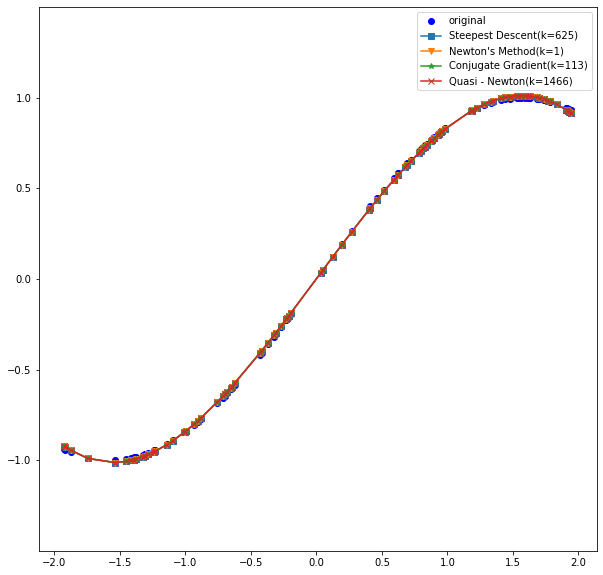

In [8]:
def function_6(x): return np.sin(x)
second_5(function_6, n=4, q=2, m=100)

[ 9.97876338e-01 -2.20555175e-04 -4.89845640e-01  7.03684921e-05
  3.43142420e-02]
[ 9.97881715e-01 -2.19689423e-04 -4.89854385e-01  7.01126321e-05
  3.43164045e-02]
[ 9.97879993e-01 -2.19170412e-04 -4.89852409e-01  6.99658741e-05
  3.43159664e-02]
[ 9.97876960e-01 -2.20455064e-04 -4.89846653e-01  7.03386486e-05
  3.43144891e-02]


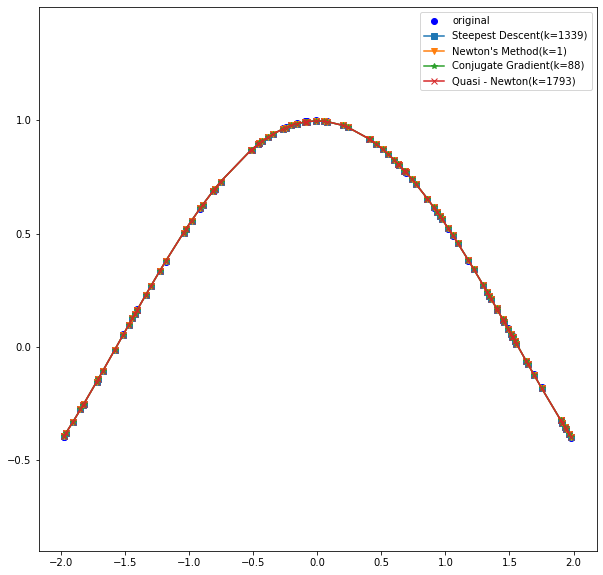

In [9]:
def function_7(x): return np.cos(x)
second_5(function_7, n=4, q=2, m=100)

[2.00058754 0.68800927 0.11417576 0.06167759 0.01303908]
[2.00059152 0.68800907 0.11416784 0.06167748 0.01304118]
[2.00058995 0.68800866 0.11417151 0.0616778  0.01304018]
[2.00058745 0.68800927 0.11417595 0.06167759 0.01303904]


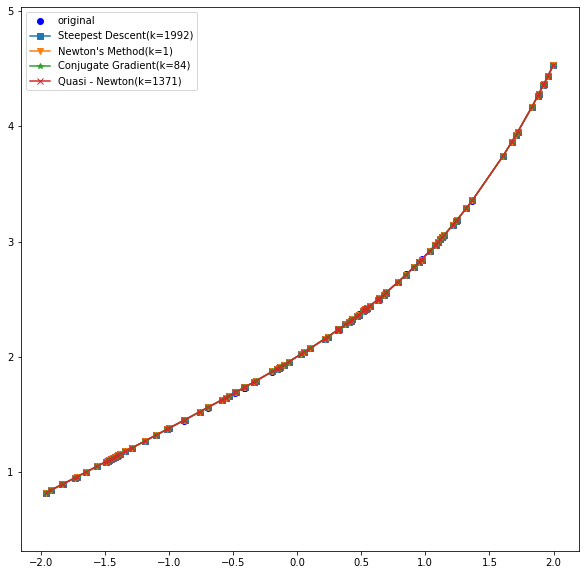

In [10]:
def function_8(x): return 2**x + np.cos(0.5*x)
second_5(function_8, n=4, q=2, m=100)

[ 5.97300822e-04  9.75141412e-01  4.99713081e+00 -1.34564806e-01
  1.03899550e-03]
[ 5.90874712e-04  9.75140818e-01  4.99714179e+00 -1.34564525e-01
  1.03606920e-03]
[ 5.87802157e-04  9.75141374e-01  4.99714532e+00 -1.34564703e-01
  1.03528126e-03]
[ 5.96433546e-04  9.75141332e-01  4.99713229e+00 -1.34564767e-01
  1.03860548e-03]


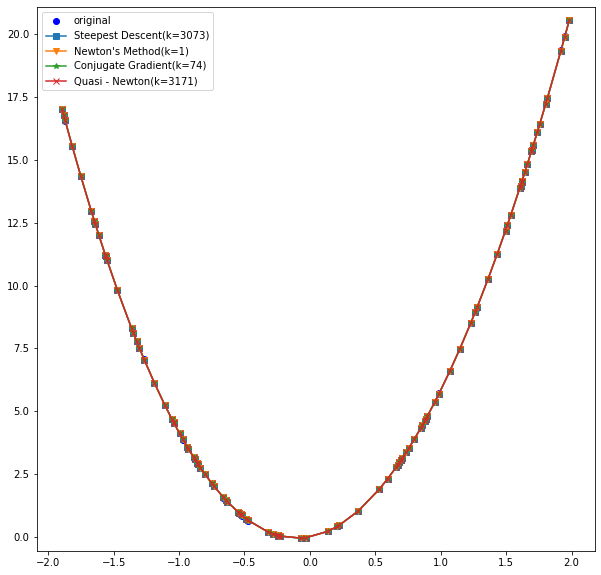

In [11]:
def function_9(x): return 5*x**2 + np.sin(x)
second_5(function_9, n=4, q=2, m=100)

[-9.99999538e+00  2.00000131e+00 -8.00545270e-06 -5.00000064e+00
  2.13028800e-06]
[-1.00000000e+01  2.00000000e+00  3.43891582e-14 -5.00000000e+00
 -1.57582281e-14]
[-9.99999938e+00  1.99999977e+00 -1.46429592e-06 -4.99999993e+00
  4.11275593e-07]
[-9.99999493e+00  2.00000144e+00 -8.78183692e-06 -5.00000070e+00
  2.33241778e-06]


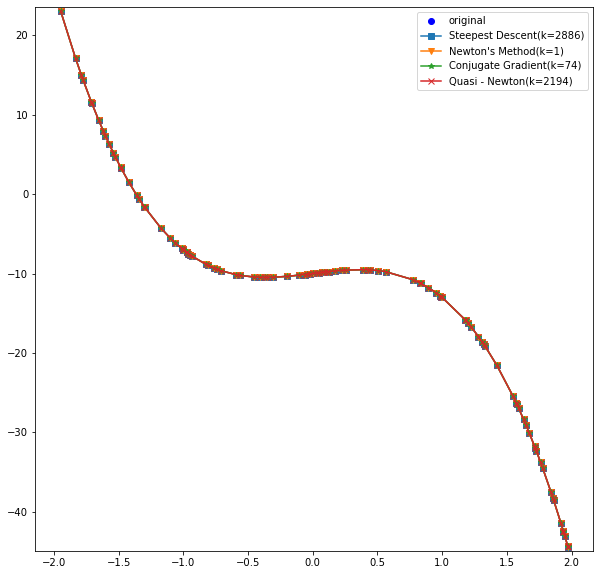

In [12]:
def function_10(x): return 2*x-5*x**3-10
second_5(function_10, n=4, q=2, m=100)